# Imports

In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneOut
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns  # Opcional, para estilização
from sklearn.metrics import explained_variance_score

# Obtenção dos dados

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Implementação

In [12]:
def train_model(X_scaled, Y_scaled):
    max_lv = 10
    lvs = []
    k=1
    loo = LeaveOneOut()
    
    calibration = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'neg_root_mean_squared_error_cal', 'explained_variance_cal', 'correlation_cal', 'rpearson_cal', 'secv_cal'])
    validation = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'secv_cv'])
    
    Y_values = pd.DataFrame(index=range(len(Y_scaled)))
    Y_values['Referencia'] = Y_scaled.flatten()  # Valores reais de Y
        
    for lv in range(1, max_lv + 1):
        pls_model = PLSRegression(n_components=lv, max_iter=500)

        # Calibração do modelo
        pls_model.fit(X_scaled, Y_scaled)
        predictions_train = pls_model.predict(X_scaled)

        # Calcula as métricas para a fase de calibração
        calibration.loc[lv, 'r2_cal'] = r2_score(Y_scaled, predictions_train)
        calibration.loc[lv, 'neg_root_mean_squared_error_cal'] = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'explained_variance_cal'] = explained_variance_score(Y_scaled, predictions_train)

        # Garantir que Y_scaled e predictions_train sejam arrays bidimensionais
        if Y_scaled.ndim == 1:
            Y_scaled = Y_scaled.reshape(-1, 1)
        if predictions_train.ndim == 1:
            predictions_train = predictions_train.reshape(-1, 1)

        correlation_cal = np.corrcoef(Y_scaled[:, 0], predictions_train[:, 0])[0, 1]  # Correlação
        calibration.loc[lv, 'correlation_cal'] = correlation_cal

        # Calcular rpearson para calibração
        rpearson_cal = correlation_cal ** 2
        calibration.loc[lv, 'rpearson_cal'] = rpearson_cal

        # Calcular o viés para calibração
        bias_cal = np.mean(predictions_train - Y_scaled)
        calibration.loc[lv, 'bias_cal'] = bias_cal

        # Calcular SE (Standard Error) para calibração
        sec_cal = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'sec_cal'] = sec_cal
        
        # Adicionar as previsões de calibração ao DataFrame Y_values
        Y_values[f'Calibracao_LV{lv}'] = predictions_train.flatten()

        # Validação cruzada (Leave-One-Out)
        predictions_cv = cross_val_predict(pls_model, X_scaled, Y_scaled, cv=loo)

        # Calcula as métricas para a validação cruzada
        validation.loc[lv, 'r2_cv'] = r2_score(Y_scaled, predictions_cv)
        validation.loc[lv, 'neg_root_mean_squared_error_cv'] = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'explained_variance_cv'] = explained_variance_score(Y_scaled, predictions_cv)

        # Garantir que predictions_cv seja array bidimensional
        if predictions_cv.ndim == 1:
            predictions_cv = predictions_cv.reshape(-1, 1)

        correlation_cv = np.corrcoef(Y_scaled[:, 0], predictions_cv[:, 0])[0, 1]  # Correlação
        validation.loc[lv, 'correlation_cv'] = correlation_cv

        # Calcular rpearson para validação cruzada
        rpearson_cv = correlation_cv ** 2
        validation.loc[lv, 'rpearson_cv'] = rpearson_cv

        # Calcular o viés para validação cruzada
        bias_cv = np.mean(predictions_cv - Y_scaled)
        validation.loc[lv, 'bias_cv'] = bias_cv

        # Calcular SECV (Standard Error of Cross Validation)
        secv_cv = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'secv_cv'] = secv_cv
        
        # Adicionar as previsões de validação ao DataFrame Y_values
        Y_values[f'Validacao_LV{lv}'] = predictions_cv.flatten()
    
               
    #print(results)
    
    for j in range(1, max_lv):
        if j + 1 <= max_lv:
            rmsecv_j = validation.loc[j + 1, 'rpearson_cv']
            rmsecv_j_plus_1 = validation.loc[j, 'rpearson_cv']
            aux = rmsecv_j / rmsecv_j_plus_1
            
            if aux > 1 and ((aux - 1) * 100 >= 2):
                lvs.append(j + 1)
                k += 1
    
    if len(lvs) == 0:
        lvs.append(1)
    
    lv_num = lvs[-1]
    
    if len(lvs) > 1:
        pls_model = PLSRegression(n_components=lvs[-2])
        pls_model.fit(X_scaled, Y_scaled)

        for w in range(k - 2):
            if pls_model.coef_.shape[1] > 3:
                if lvs[w + 1] < pls_model.coef_.shape[0] and pls_model.coef_[lvs[w + 1], 3] < 1:
                    lv_num = lvs[w]
                    break

        model = pls_model.fit(X_scaled, Y_scaled)
    else:
        pls_model = PLSRegression(n_components=lvs[0])
        model = pls_model.fit(X_scaled, Y_scaled)

    
    return calibration, validation, lv_num, model, Y_values

def center_data(X, Y):
    # Calcula as médias para cada coluna
    mx = np.mean(X, axis=0)
    
    # Calcula a média para Y
    my = np.mean(Y)
    
    # Centraliza as colunas na média
    abs_centered = X - mx
    qua_centered = Y - my
       
    return abs_centered, qua_centered, mx, my

def predict(model, X_pred, y_pred, lv_number):
    X_centered, _, _, _ = center_data(X_pred.iloc[:,6:].values, y_pred.values)
    pred = model.predict(X_pred.iloc[:,6:].values)
       
    y_pred = y_pred.values  # Convertendo Series para NumPy array
    pred = pred.reshape(-1, 1)  # Garantindo que pred seja 2D

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    Y_predict = pd.DataFrame(columns=['Amostra', 'Y_pred', 'Y_true', 'Deviation'])
    
    prediction = pd.DataFrame(columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'bias_cv', 'secv_cv'])
    
    prediction.loc[lv_number, 'r2_p'] = r2_score(y_pred, pred)
    prediction.loc[lv_number, 'neg_root_mean_squared_error_p'] = np.sqrt(mean_squared_error(y_pred, pred))
    prediction.loc[lv_number, 'explained_variance_p'] = explained_variance_score(y_pred, pred)
    prediction.loc[lv_number, 'correlation_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1]
    prediction.loc[lv_number, 'rpearson_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1] ** 2  # Quadrado do coeficiente de correlação
    prediction.loc[lv_number, 'bias_p'] = np.mean(pred - y_pred)  # Viés
    prediction.loc[lv_number, 'sec_p'] = np.sqrt(np.mean((pred - y_pred) ** 2))  # Erro quadrático de calibração
    
    Y_predict['Y_pred'] = pred.flatten()
    Y_predict['Y_true'] = y_pred.flatten()
    Y_predict['Deviation'] = pred.flatten() - y_pred.flatten()
    Y_predict['Amostra'] = X_pred.iloc[0:,0].tolist()
        
    return prediction, Y_predict

def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    
    slope_pred, offset_pred = np.polyfit(Y_true, Y_pred, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2_pred = r2_score(Y_true, Y_pred)
    
    slope_opt, offset_opt = np.polyfit(Y_true, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true, Y_opt))
    r2_opt = r2_score(Y_true, Y_opt)
    
    metrics_dict = pd.DataFrame({
    'Y': ['Referência', 'Predição'],
    'Slope': [slope_opt,slope_pred],
    'Offset': [offset_opt, offset_pred],
    'RMSE': [rmse_opt, rmse_pred],
    'R²': [r2_opt, r2_pred]
    })
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)
    
    # Scatter plot for predicted values
    plt.scatter(Y_true, Y_pred, color='red', label='Predicted', marker='o', alpha=0.7)
       
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.legend(loc='lower right')
    plt.show()
    
    return metrics_dict

def pred_plot(Y_predict):
    plt.figure(figsize=(15, 5))
    plt.title("Predicted with Deviation")

    # Plotar cada amostra
    for sample in Y_predict.index:
        y_pred = Y_predict.loc[sample, 'Y_pred']
        deviation = Y_predict.loc[sample, 'Deviation']
        y_true = Y_predict.loc[sample, 'Y_true']
        
        # Criar os dados do boxplot para esta amostra
        data_boxplot = [y_pred - deviation, y_pred, y_pred + deviation]
        
        # Plotar o boxplot
        plt.boxplot(data_boxplot, positions=[Y_predict.index.get_loc(sample)], widths=0.6, patch_artist=True, 
                    boxprops=dict(edgecolor='blue', linewidth=1.5),
                    whiskerprops=dict(color='red'),
                    capprops=dict(color='red'),
                    medianprops=dict(color='black'))
        
    plt.xticks(ticks=range(len(Y_predict.index)), labels=Y_predict['Amostra'], rotation=90)
    plt.xlabel('Samples')
    plt.ylabel('Predicted Y (SS FT-IR factor-6)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def build_model(X_cal, Y_cal, X_val, Y_val):
       
    Y_pred = Y_val
    X_pred = X_val
       
    X = X_cal
    Y = Y_cal
    
    #abs_scaled, qua_scaled, m_abs, m_qua = center_data(X.iloc[:,6:].values, Y.values)
    calibration, validation, lv_num, model, Y_values = train_model(X.iloc[:,6:].values, Y.values)
    print(f'Número de componentes: {lv_num}')
        
    prediction, Y_predict = predict(model, X_pred, Y_pred, lv_num)
    
    Y_true = Y_values.iloc[:, 0]  # Primeira coluna de Y_values
    Y_opt = Y_values[f'Calibracao_LV{lv_num}']  # Coluna específica de calibração
    Y_pred = Y_values[f'Validacao_LV{lv_num}']  # Coluna específica de validação
    plot_infos = plot_pred_vs_ref(Y_true, Y_pred, Y_opt)
    chart_data = pd.DataFrame({
    'Sample': Y_values.index,  # Identificador da amostra, pode ser index ou outra coluna específica
    'Y_true': Y_true,
    'Y_opt': Y_opt,
    'Y_pred': Y_pred
    })  
    display(chart_data)
    pred_plot(Y_predict)
    display(Y_predict)
    
    return calibration, validation, Y_predict, plot_infos



In [32]:
plot_infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'Slope', 'Offset', 'RMSE', 'R²'])
plot_infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'Slope', 'Offset', 'RMSE', 'R²'])
plot_infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'Slope', 'Offset', 'RMSE', 'R²'])

def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre


## MSC - PLSR

Número de componentes: 8


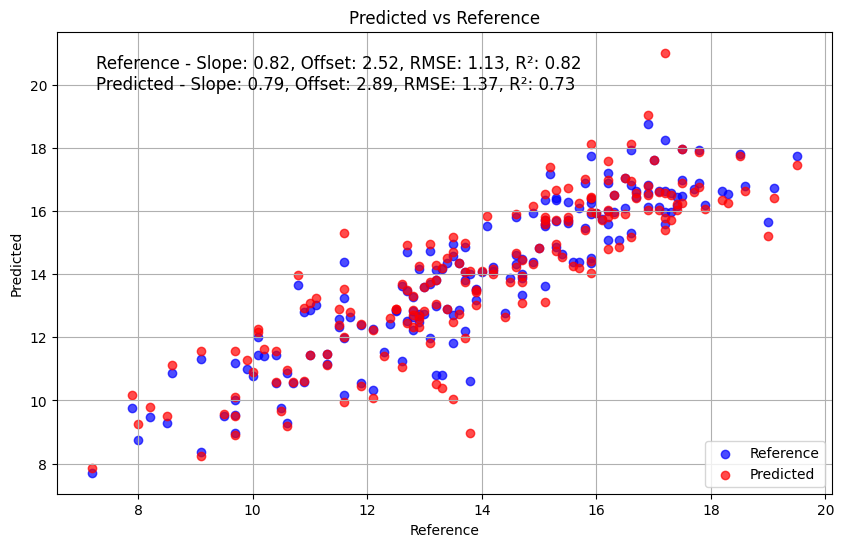

,Sample,Y_true,Y_opt,Y_pred
0,0,11.6,10.169548,9.966059
1,1,11.3,11.161901,11.121174
2,2,11.3,11.485463,11.481367
3,3,12.7,12.509487,12.458253
4,4,12.8,13.291377,13.297970
...,...,...,...,...
170,170,15.2,17.170577,17.391497
171,171,17.2,15.590909,15.384798
172,172,15.9,16.252452,16.447224
173,173,16.6,16.829450,16.944465


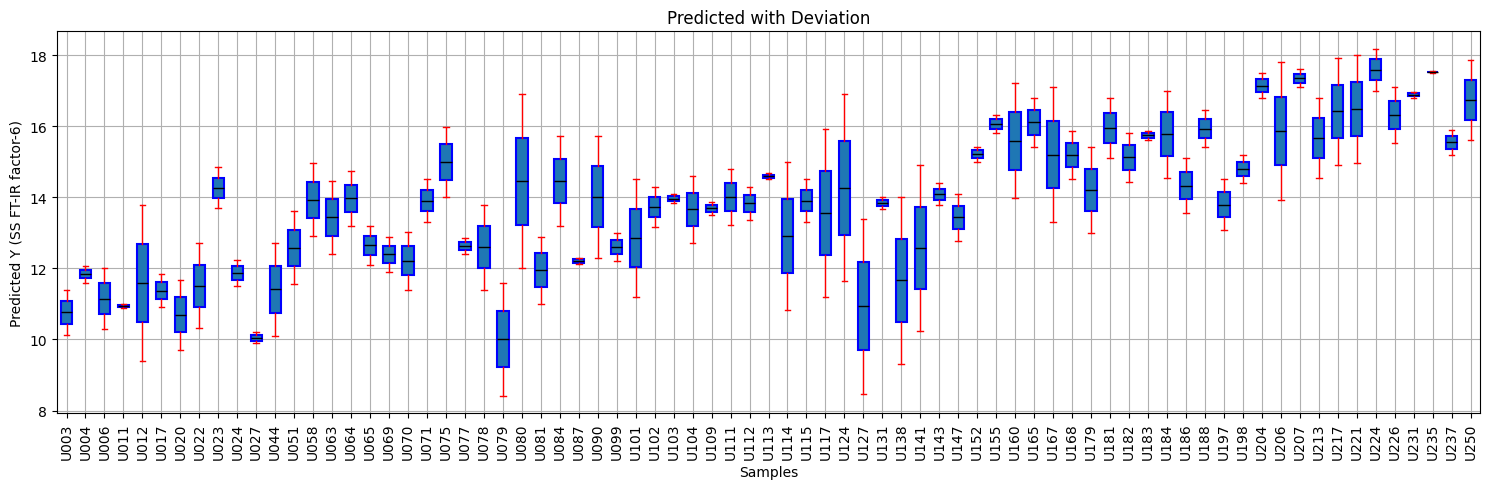

,Amostra,Y_pred,Y_true,Deviation
0,U003,10.765654,11.4,-0.634346
1,U004,11.833475,11.6,0.233475
2,U006,11.150110,12.0,-0.849890
3,U011,10.938767,11.0,-0.061233
4,U012,11.589076,9.4,2.189076
...,...,...,...,...
70,U226,16.306330,17.1,-0.793670
71,U231,16.882670,16.8,0.082670
72,U235,17.521268,17.5,0.021268
73,U237,15.543267,15.9,-0.356733


In [33]:
calibration_msc_sst, validation_msc_sst, Y_predict_msc_sst, plot_infos = build_model(df_msc_cal, df_msc_cal['SST'], df_msc_val, df_msc_val['SST'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'SST')

Número de componentes: 8


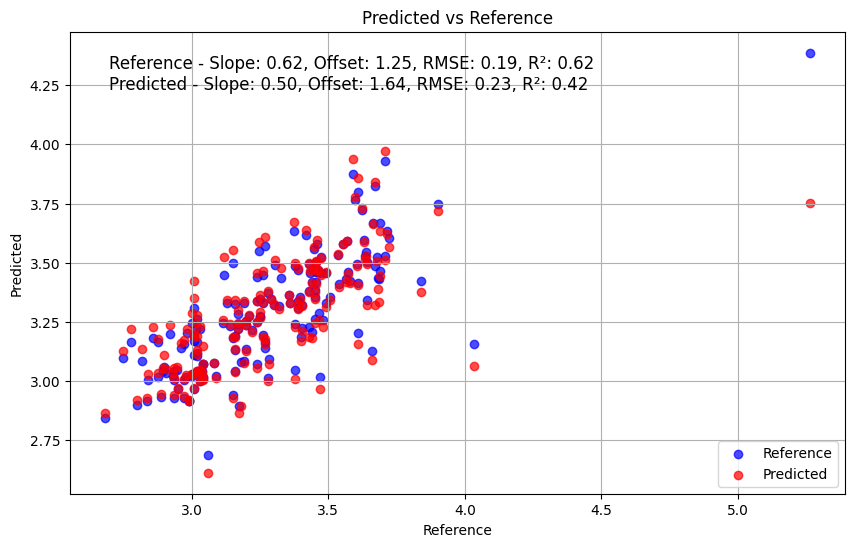

,Sample,Y_true,Y_opt,Y_pred
0,0,3.270,3.569201,3.607260
1,1,3.490,3.328604,3.313263
2,2,3.570,3.592535,3.593826
3,3,3.607,3.494378,3.485277
4,4,3.643,3.341218,3.319752
...,...,...,...,...
170,170,3.130,3.328902,3.344726
171,171,3.190,3.328043,3.338373
172,172,3.200,3.256103,3.253279
173,173,3.210,3.274944,3.277357


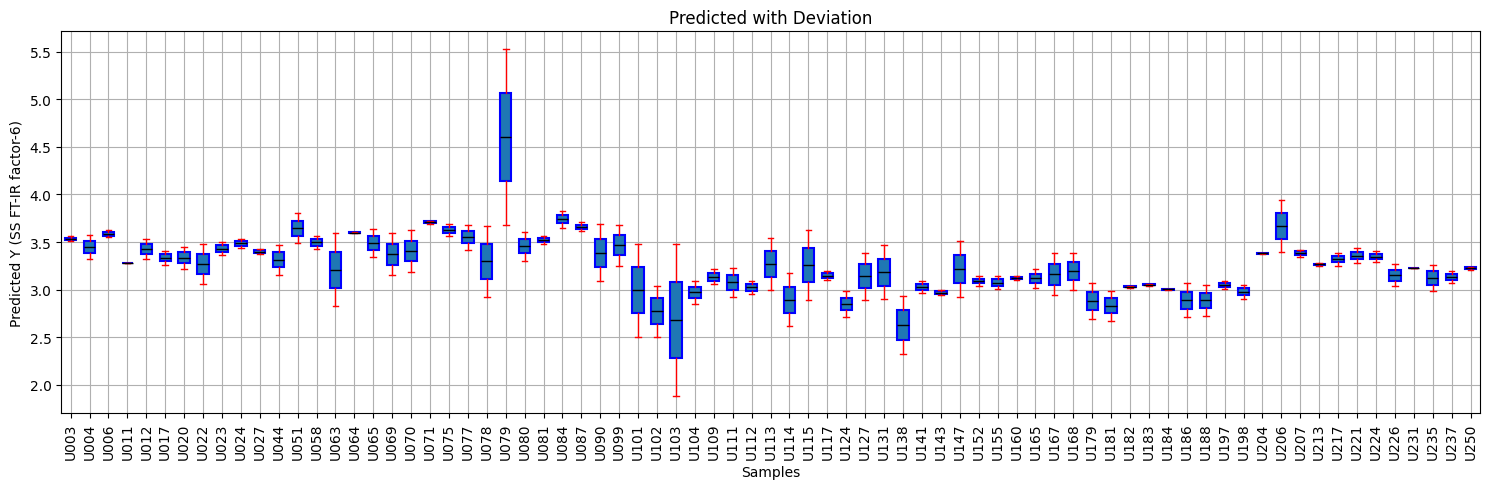

,Amostra,Y_pred,Y_true,Deviation
0,U003,3.534835,3.560,-0.025165
1,U004,3.446003,3.570,-0.123997
2,U006,3.586391,3.550,0.036391
3,U011,3.280004,3.282,-0.001996
4,U012,3.425171,3.318,0.107171
...,...,...,...,...
70,U226,3.151553,3.270,-0.118447
71,U231,3.226929,3.230,-0.003071
72,U235,3.121702,3.260,-0.138298
73,U237,3.133409,3.200,-0.066591


In [34]:
calibration_msc_ph, validation_msc_ph, Y_predict_msc_ph, plot_infos = build_model(df_msc_cal, df_msc_cal['PH'], df_msc_val, df_msc_val['PH'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'PH')

Número de componentes: 10


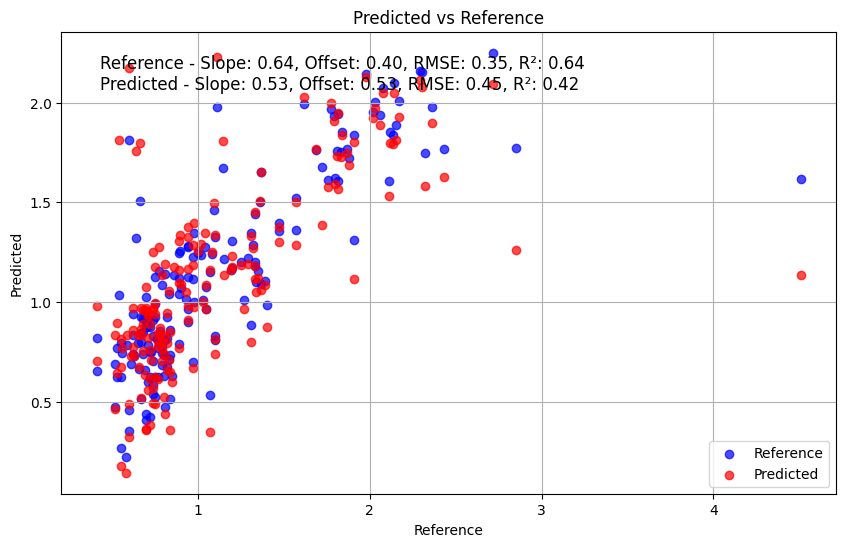

,Sample,Y_true,Y_opt,Y_pred
0,0,1.98,2.145772,2.130044
1,1,1.91,1.837999,1.801316
2,2,2.06,1.937558,1.889354
3,3,1.62,1.993073,2.026038
4,4,1.76,1.611304,1.577069
...,...,...,...,...
170,170,0.82,0.817307,0.793207
171,171,0.68,0.847103,0.886800
172,172,0.69,0.659883,0.632596
173,173,0.73,0.749068,0.708606


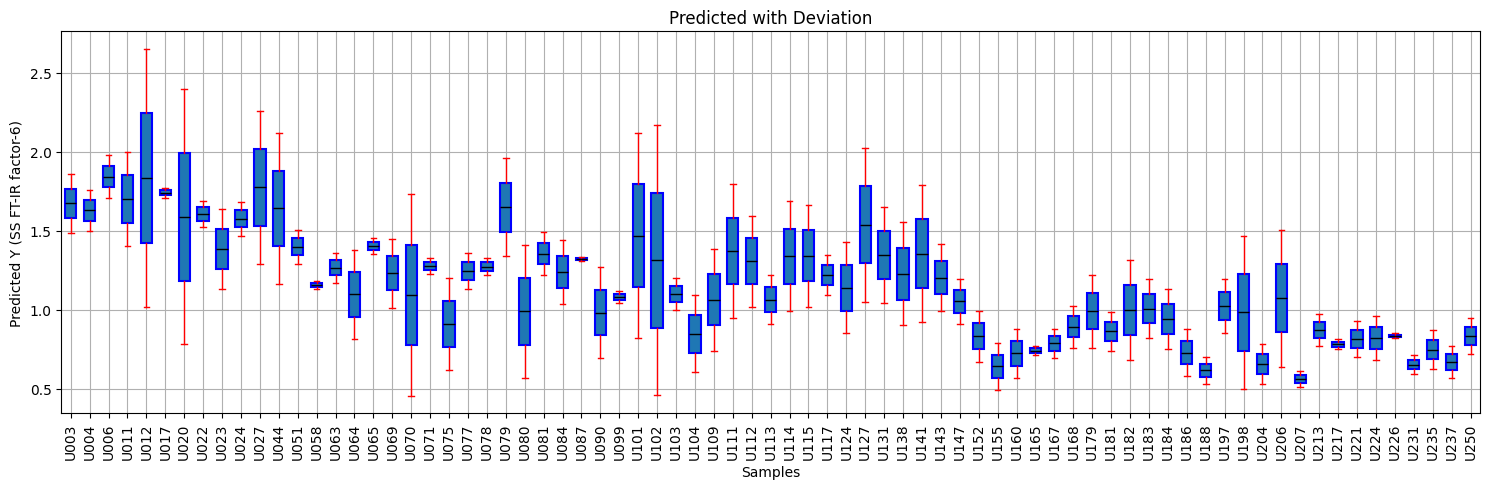

,Amostra,Y_pred,Y_true,Deviation
0,U003,1.673663,1.860,-0.186337
1,U004,1.628622,1.760,-0.131378
2,U006,1.843132,1.980,-0.136868
3,U011,1.700664,2.000,-0.299336
4,U012,1.833725,1.014,0.819725
...,...,...,...,...
70,U226,0.834717,0.820,0.014717
71,U231,0.652597,0.710,-0.057403
72,U235,0.746608,0.870,-0.123392
73,U237,0.667236,0.770,-0.102764


In [35]:
calibration_msc_at, validation_msc_at, Y_predict_msc_at, plot_infos = build_model(df_msc_cal, df_msc_cal['AT'], df_msc_val, df_msc_val['AT'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'AT')


Número de componentes: 10


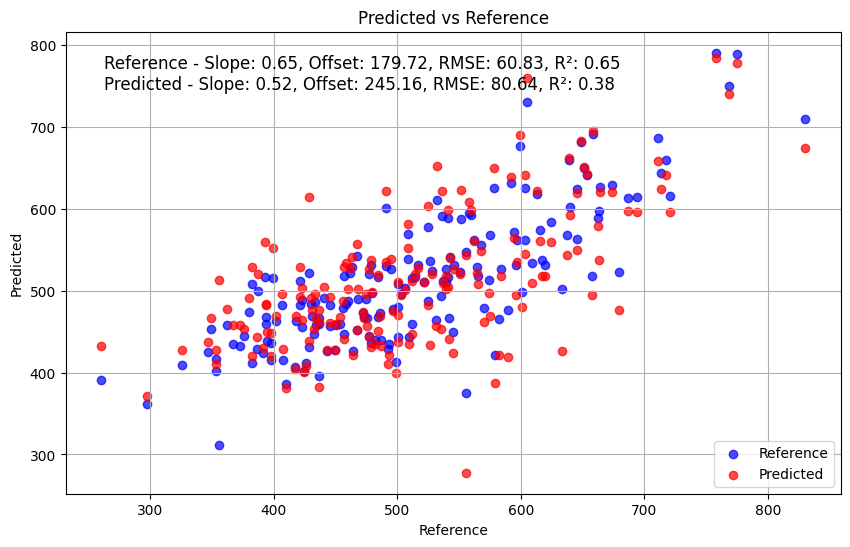

,Sample,Y_true,Y_opt,Y_pred
0,0,557.941,595.082459,608.181221
1,1,392.806,516.272585,559.717120
2,2,645.933,563.226024,549.022297
3,3,559.380,592.659726,598.976453
4,4,619.812,530.701503,517.377052
...,...,...,...,...
170,170,436.857,459.655656,461.213020
171,171,407.748,415.306320,429.238345
172,172,410.293,385.437862,381.288135
173,173,353.403,416.236830,427.848711


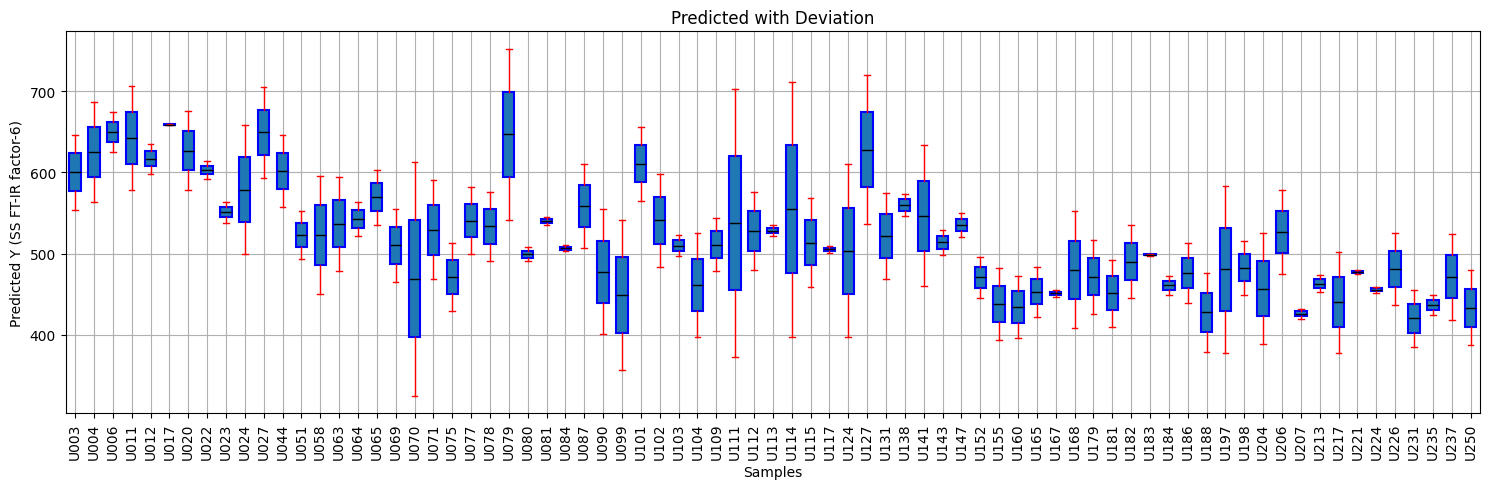

,Amostra,Y_pred,Y_true,Deviation
0,U003,600.152181,553.736,46.416181
1,U004,625.390141,564.029,61.361141
2,U006,650.169813,675.042,-24.872187
3,U011,642.608471,578.085,64.523471
4,U012,616.653975,598.008,18.645975
...,...,...,...,...
70,U226,481.112177,436.414,44.698177
71,U231,420.024424,455.451,-35.426576
72,U235,436.787615,424.239,12.548615
73,U237,471.536212,524.627,-53.090788


In [36]:
calibration_msc_f, validation_msc_f, Y_predict_msc_f, plot_infos = build_model(df_msc_cal, df_msc_cal['FIRMEZA (N)'], df_msc_val, df_msc_val['FIRMEZA (N)'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'FIRMEZA (N)')


Número de componentes: 4


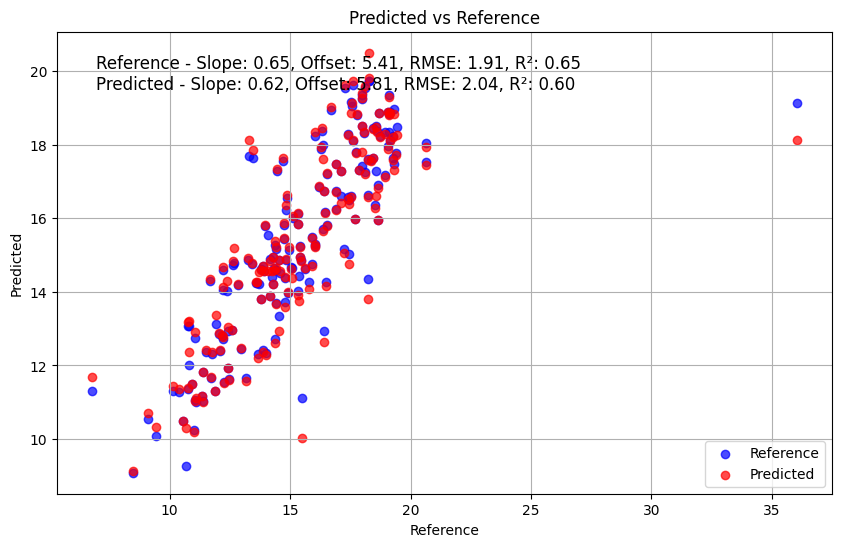

,Sample,Y_true,Y_opt,Y_pred
0,0,11.866295,11.317640,11.314345
1,1,12.206166,12.716468,12.771935
2,2,12.404207,11.943715,11.939763
3,3,14.014046,12.337387,12.295881
4,4,13.786897,13.807895,13.817581
...,...,...,...,...
170,170,16.703325,18.953385,19.034575
171,171,18.715851,18.245390,18.219191
172,172,18.260626,19.732484,19.816480
173,173,17.614441,19.627277,19.734924


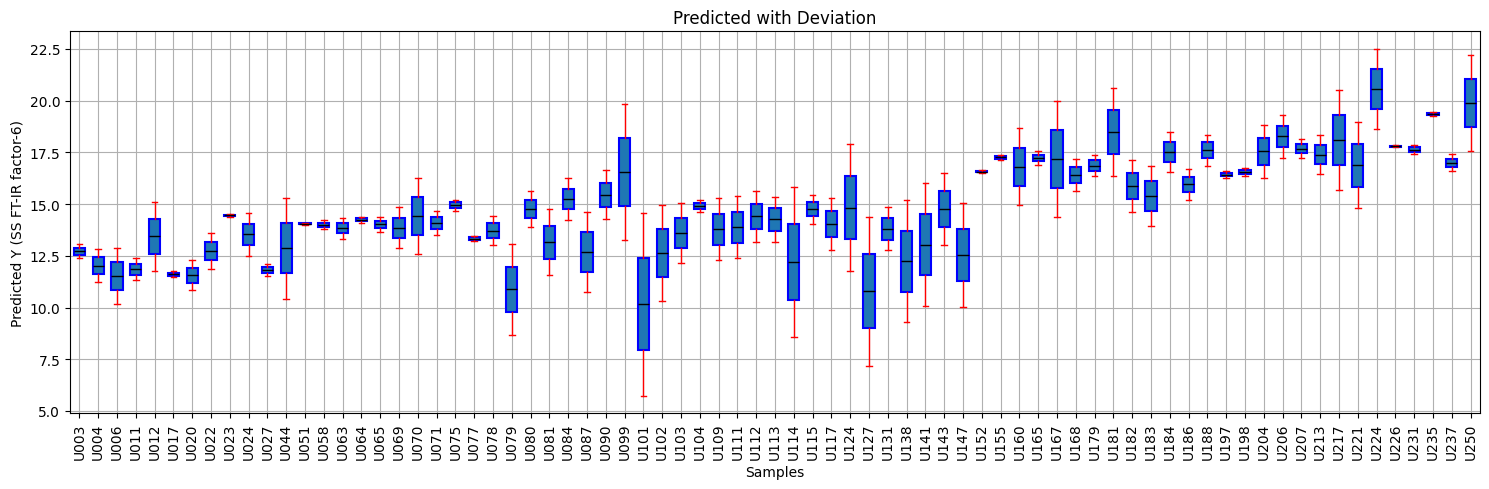

,Amostra,Y_pred,Y_true,Deviation
0,U003,12.723859,12.400951,0.322908
1,U004,12.022171,12.813938,-0.791768
2,U006,11.506884,12.867540,-1.360656
3,U011,11.851776,12.370821,-0.519045
4,U012,13.434448,11.784548,1.649899
...,...,...,...,...
70,U226,17.801067,17.858437,-0.057370
71,U231,17.632381,17.851070,-0.218689
72,U235,19.368645,19.461815,-0.093170
73,U237,16.994292,17.402479,-0.408187


In [37]:
calibration_msc_f, validation_msc_f, Y_predict_msc_f, plot_infos = build_model(df_msc_cal, df_msc_cal['UBS (%)'], df_msc_val, df_msc_val['UBS (%)'])

plot_infos_msc = add_plot_infos(plot_infos_msc, plot_infos, 'UBS (%)')

In [38]:
plot_infos_msc.to_excel('plot_infos_plsr_msc.xlsx', index=False)
plot_infos_msc

,Attribute,Y,Slope,Offset,RMSE,R²
0,SST,Referência,0.819934,2.520107,1.127221,0.819934
1,SST,Predição,0.794042,2.888446,1.368351,0.734656
2,PH,Referência,0.619416,1.250036,0.190269,0.619416
3,PH,Predição,0.500726,1.638481,0.234505,0.421879
4,AT,Referência,0.641407,0.402620,0.351165,0.641407
5,AT,Predição,0.533295,0.528036,0.445926,0.421762
6,FIRMEZA (N),Referência,0.649683,179.716286,60.827107,0.649683
7,FIRMEZA (N),Predição,0.520817,245.157504,80.642385,0.384265
8,UBS (%),Referência,0.647443,5.407884,1.910040,0.647443
9,UBS (%),Predição,0.620626,5.813119,2.039323,0.598102


## SNV - PLSR

Número de componentes: 8


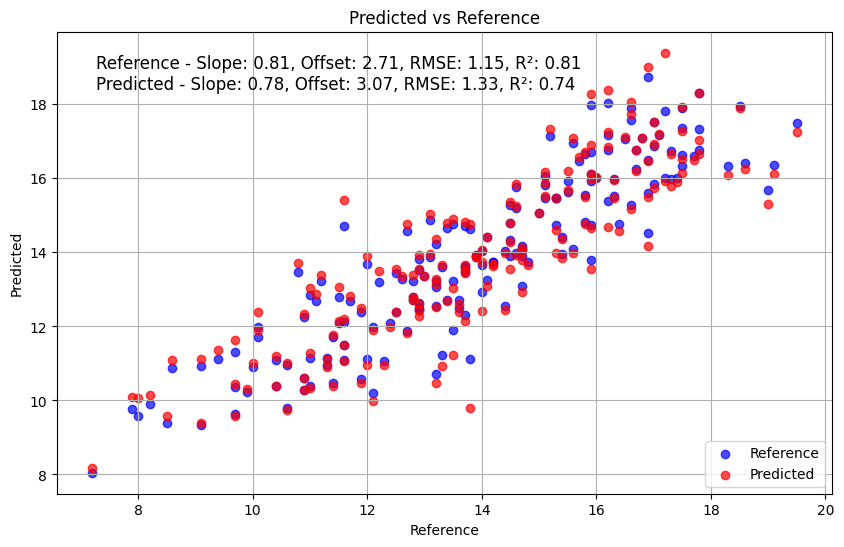

,Sample,Y_true,Y_opt,Y_pred
0,0,11.3,10.952560,10.912264
1,1,11.4,10.457230,10.380668
2,2,11.6,12.131115,12.193379
3,3,11.3,11.143938,11.128182
4,4,12.0,11.117168,10.959056
...,...,...,...,...
170,170,15.2,17.145344,17.333563
171,171,15.9,16.716496,16.897947
172,172,16.6,17.573159,17.731815
173,173,16.2,17.167130,17.265858


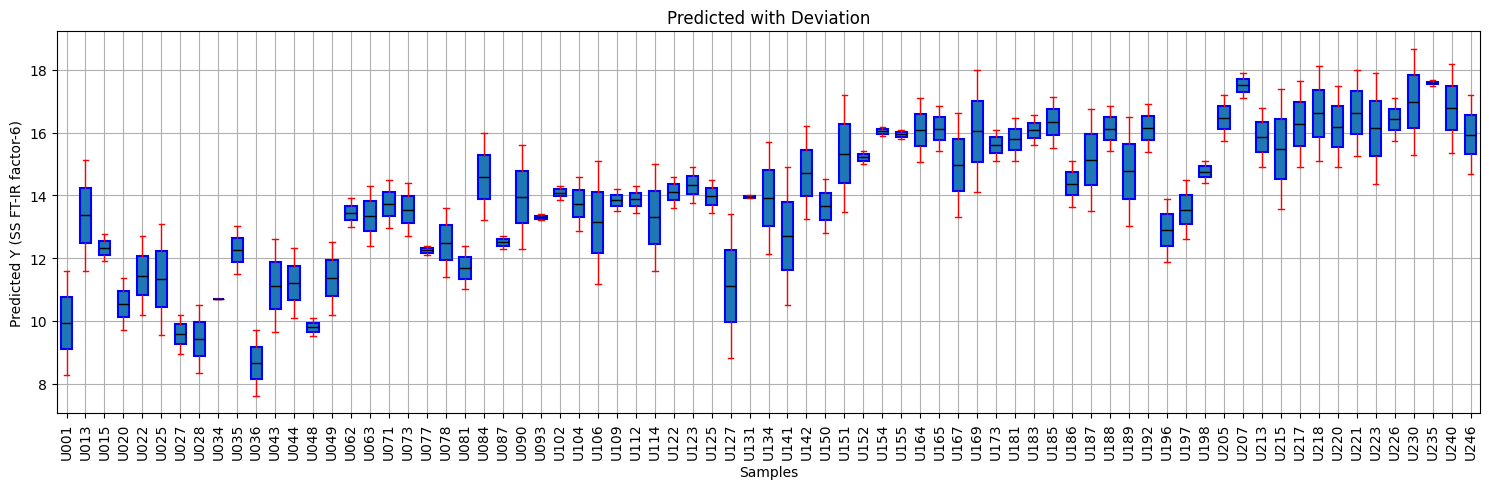

,Amostra,Y_pred,Y_true,Deviation
0,U001,9.931545,11.6,-1.668455
1,U013,13.359038,11.6,1.759038
2,U015,12.326243,11.9,0.426243
3,U020,10.526733,9.7,0.826733
4,U022,11.438147,12.7,-1.261853
...,...,...,...,...
70,U226,16.420038,17.1,-0.679962
71,U230,16.988952,15.3,1.688952
72,U235,17.582186,17.5,0.082186
73,U240,16.781837,18.2,-1.418163


In [39]:
calibration_snv_sst, validation_snv_sst, Y_predict_snv_sst, plot_infos = build_model(df_snv_cal, df_snv_cal['SST'], df_snv_val, df_snv_val['SST'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'SST')

Número de componentes: 9


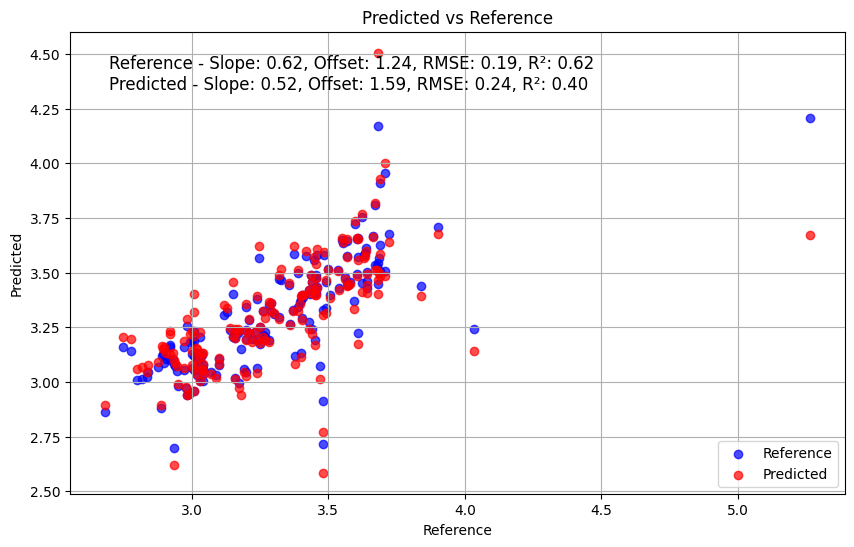

,Sample,Y_true,Y_opt,Y_pred
0,0,3.49,3.336172,3.316002
1,1,3.56,3.480830,3.470734
2,2,3.57,3.459038,3.439225
3,3,3.57,3.646953,3.653207
4,4,3.55,3.648419,3.659356
...,...,...,...,...
170,170,3.13,3.321936,3.336673
171,171,3.20,3.344408,3.356545
172,172,3.21,3.281740,3.289095
173,173,3.20,3.236161,3.235339


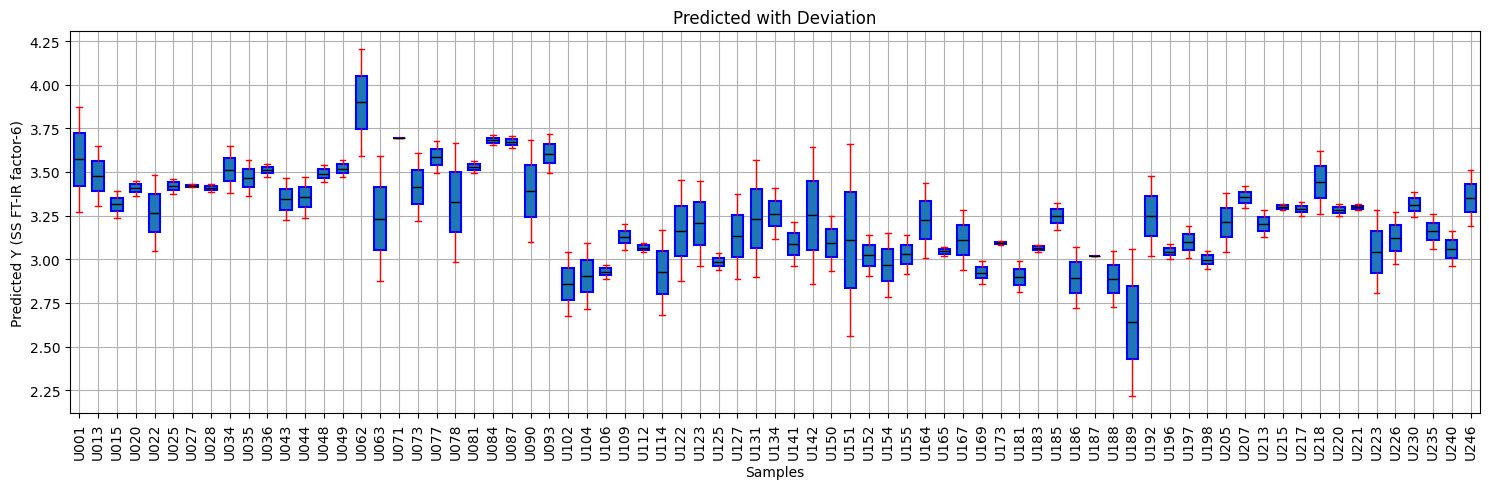

,Amostra,Y_pred,Y_true,Deviation
0,U001,3.571760,3.270,0.301760
1,U013,3.478507,3.306,0.172507
2,U015,3.313855,3.390,-0.076145
3,U020,3.406855,3.450,-0.043145
4,U022,3.263899,3.482,-0.218101
...,...,...,...,...
70,U226,3.122136,3.270,-0.147864
71,U230,3.313472,3.240,0.073472
72,U235,3.160150,3.260,-0.099850
73,U240,3.059669,3.160,-0.100331


In [40]:
calibration_snv_ph, validation_snv_ph, Y_predict_snv_ph, plot_infos = build_model(df_snv_cal, df_snv_cal['PH'], df_snv_val, df_snv_val['PH'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'PH')

Número de componentes: 6


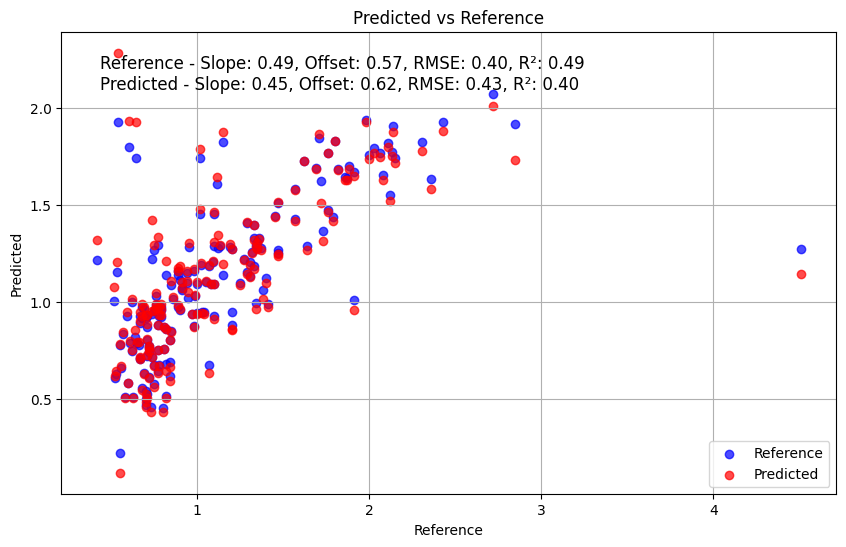

,Sample,Y_true,Y_opt,Y_pred
0,0,1.91,1.670513,1.650662
1,1,1.86,1.647250,1.631617
2,2,1.76,1.769328,1.769433
3,3,2.06,1.767284,1.750072
4,4,1.98,1.937219,1.930191
...,...,...,...,...
170,170,0.82,0.519741,0.506095
171,171,0.69,0.633132,0.628335
172,172,0.73,0.458267,0.435767
173,173,0.63,0.510349,0.505638


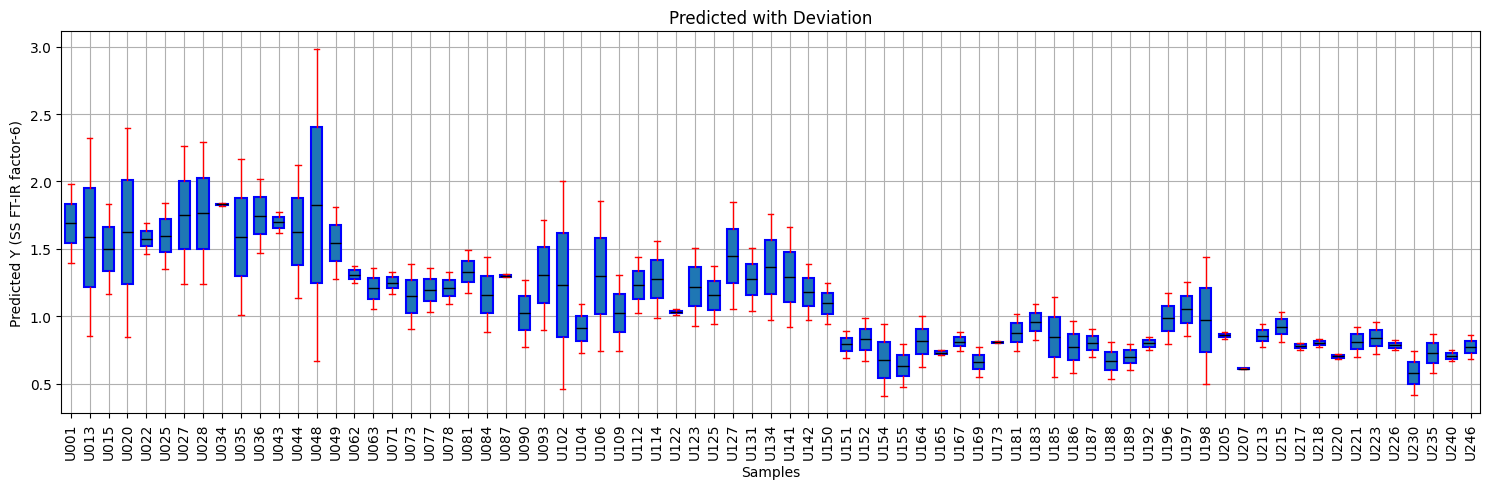

,Amostra,Y_pred,Y_true,Deviation
0,U001,1.688650,1.98,-0.291350
1,U013,1.584867,2.32,-0.735133
2,U015,1.498722,1.83,-0.331278
3,U020,1.624287,2.40,-0.775713
4,U022,1.575524,1.69,-0.114476
...,...,...,...,...
70,U226,0.784671,0.82,-0.035329
71,U230,0.576979,0.74,-0.163021
72,U235,0.725799,0.87,-0.144201
73,U240,0.706747,0.75,-0.043253


In [41]:
calibration_snv_at, validation_snv_at, Y_predict_snv_at, plot_infos = build_model(df_snv_cal, df_snv_cal['AT'], df_snv_val, df_snv_val['AT'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'AT')

Número de componentes: 9


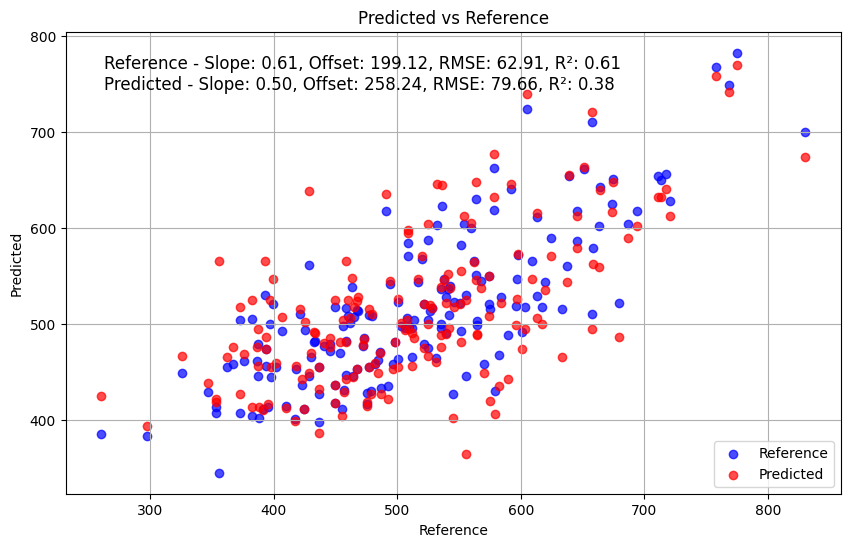

,Sample,Y_true,Y_opt,Y_pred
0,0,392.806,529.932847,565.526837
1,1,553.736,604.274577,612.163751
2,2,564.029,630.381055,647.411775
3,3,645.933,586.700669,579.319566
4,4,675.042,651.413981,647.652701
...,...,...,...,...
170,170,436.857,454.709441,455.466788
171,171,410.293,414.384671,412.172937
172,172,353.403,406.906649,418.569025
173,173,401.771,454.557057,458.628276


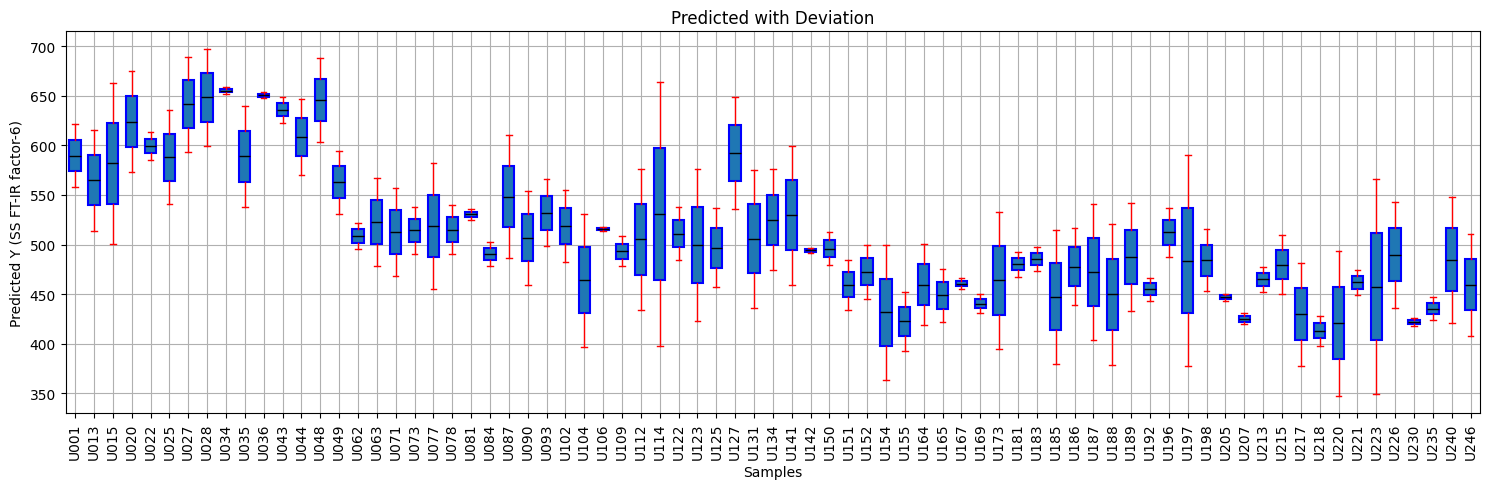

,Amostra,Y_pred,Y_true,Deviation
0,U001,589.657685,557.941,31.716685
1,U013,564.956522,615.938,-50.981478
2,U015,581.743988,662.756,-81.012012
3,U020,624.008038,675.152,-51.143962
4,U022,599.318653,613.835,-14.516347
...,...,...,...,...
70,U226,489.780520,436.414,53.366520
71,U230,421.935643,425.789,-3.853357
72,U235,435.457441,424.239,11.218441
73,U240,484.634304,421.140,63.494304


In [42]:
calibration_snv_f, validation_snv_f, Y_predict_snv_f, plot_infos = build_model(df_snv_cal, df_snv_cal['FIRMEZA (N)'], df_snv_val, df_snv_val['FIRMEZA (N)'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'FIRMEZA (N)')

Número de componentes: 6


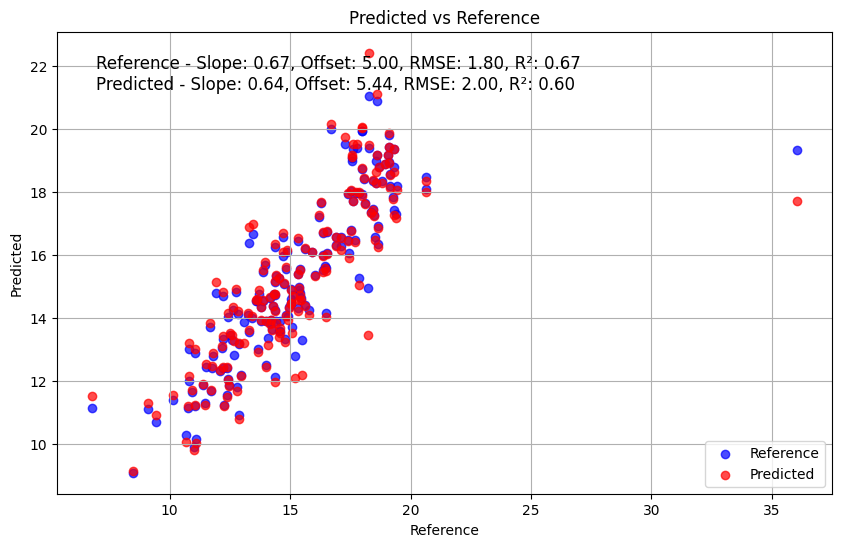

,Sample,Y_true,Y_opt,Y_pred
0,0,12.206166,12.408146,12.446230
1,1,12.400951,12.416759,12.433961
2,2,12.813938,11.803141,11.658742
3,3,12.404207,12.048794,12.036016
4,4,12.867540,10.921841,10.770114
...,...,...,...,...
170,170,16.703325,19.982290,20.145154
171,171,18.260626,19.390372,19.488275
172,172,17.614441,19.353256,19.519739
173,173,17.966201,19.937115,20.035898


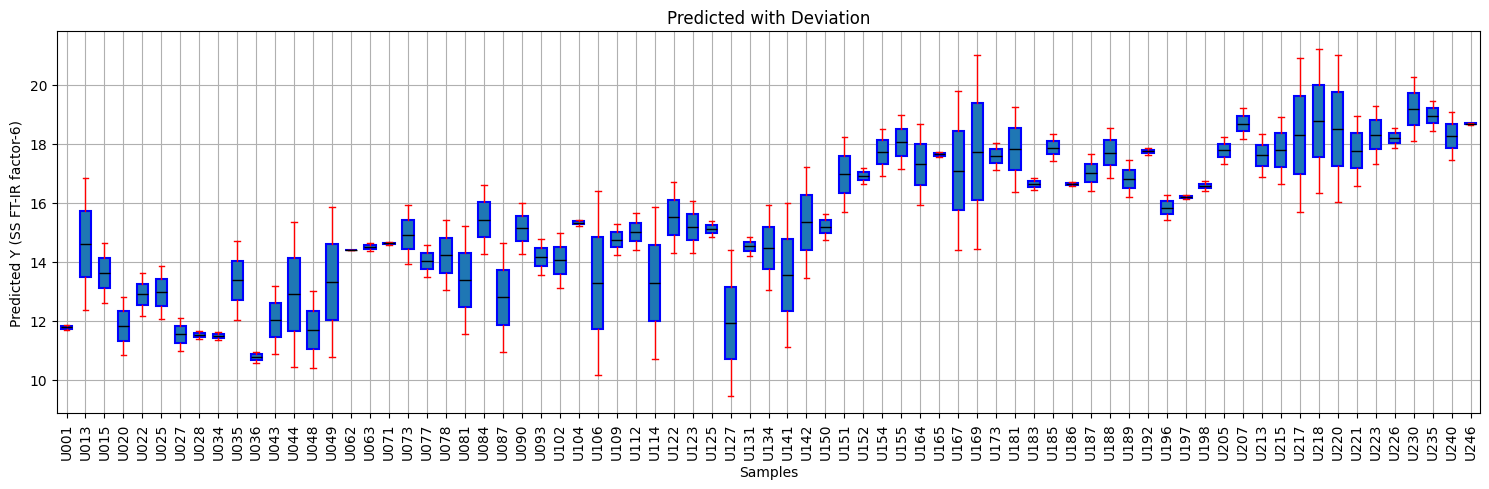

,Amostra,Y_pred,Y_true,Deviation
0,U001,11.769260,11.866295,-0.097035
1,U013,14.600403,12.376837,2.223567
2,U015,13.609630,12.583001,1.026629
3,U020,11.819328,10.825132,0.994195
4,U022,12.895761,13.621190,-0.725430
...,...,...,...,...
70,U226,18.198215,17.858437,0.339777
71,U230,19.180407,18.106641,1.073766
72,U235,18.951430,19.461815,-0.510385
73,U240,18.265993,19.066069,-0.800075


In [43]:
calibration_snv_ubs, validation_snv_ubs, Y_predict_snv_ubs, plot_infos = build_model(df_snv_cal, df_snv_cal['UBS (%)'], df_snv_val, df_snv_val['UBS (%)'])

plot_infos_snv = add_plot_infos(plot_infos_snv, plot_infos, 'UBS (%)')

In [44]:
plot_infos_snv.to_excel('plot_infos_plsr_snv.xlsx', index=False)
plot_infos_snv

,Attribute,Y,Slope,Offset,RMSE,R²
0,SST,Referência,0.805174,2.711639,1.148838,0.805174
1,SST,Predição,0.779399,3.067603,1.331392,0.738338
2,PH,Referência,0.624367,1.240089,0.191920,0.624367
3,PH,Predição,0.518092,1.592154,0.242754,0.399023
4,AT,Referência,0.494666,0.568706,0.397502,0.494666
5,AT,Predição,0.453276,0.617574,0.434809,0.395359
6,FIRMEZA (N),Referência,0.612707,199.119258,62.911160,0.612707
7,FIRMEZA (N),Predição,0.498008,258.235708,79.662444,0.378999
8,UBS (%),Referência,0.672673,5.000182,1.800230,0.672673
9,UBS (%),Predição,0.642703,5.443534,1.996812,0.597283


## SG - PLSR

Número de componentes: 6


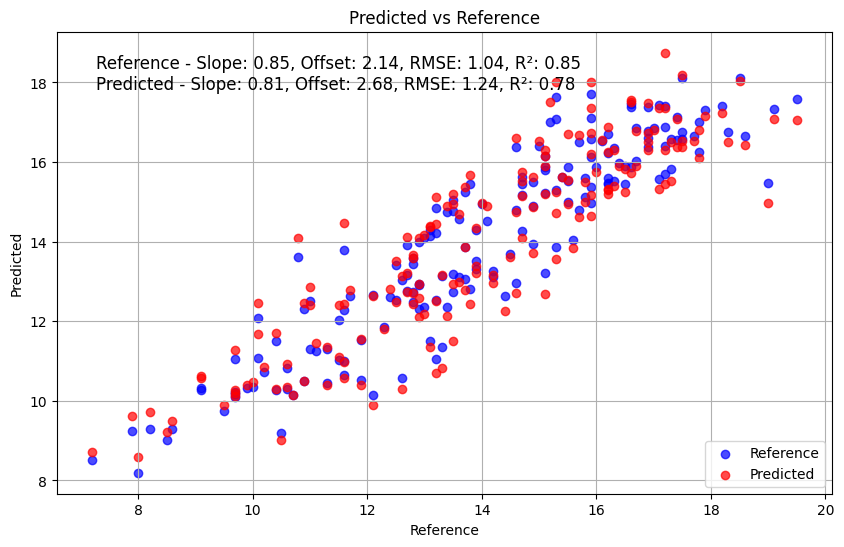

,Sample,Y_true,Y_opt,Y_pred
0,0,11.6,10.637509,10.562477
1,1,11.3,10.442115,10.400328
2,2,11.3,11.292064,11.341777
3,3,12.7,12.766977,12.742693
4,4,12.8,12.473370,12.438040
...,...,...,...,...
170,170,15.2,17.006021,17.518342
171,171,17.2,15.688576,15.456275
172,172,15.9,16.125825,16.198222
173,173,16.6,17.374571,17.565026


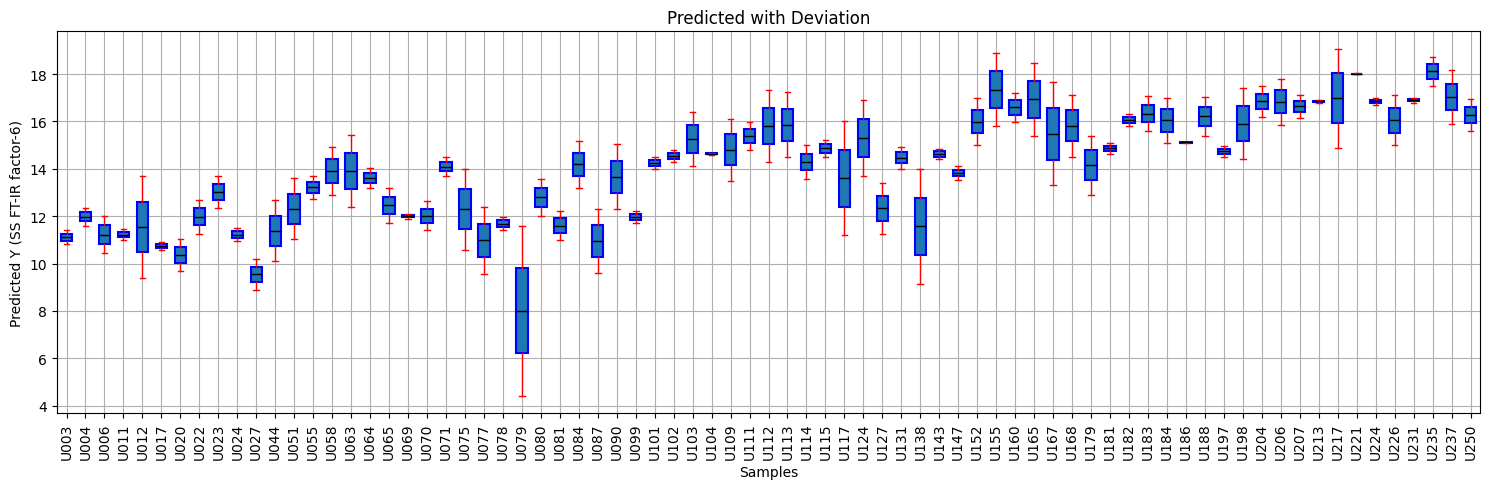

,Amostra,Y_pred,Y_true,Deviation
0,U003,11.116281,11.4,-0.283719
1,U004,11.978127,11.6,0.378127
2,U006,11.228296,12.0,-0.771704
3,U011,11.223930,11.0,0.223930
4,U012,11.544024,9.4,2.144024
...,...,...,...,...
70,U226,16.052512,17.1,-1.047488
71,U231,16.901120,16.8,0.101120
72,U235,18.118140,17.5,0.618140
73,U237,17.029277,15.9,1.129277


In [45]:
calibration_sg_sst, validation_sg_sst, Y_predict_sg_sst, plot_infos = build_model(df_sg_cal, df_sg_cal['SST'], df_sg_val, df_sg_val['SST'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'SST')

Número de componentes: 8


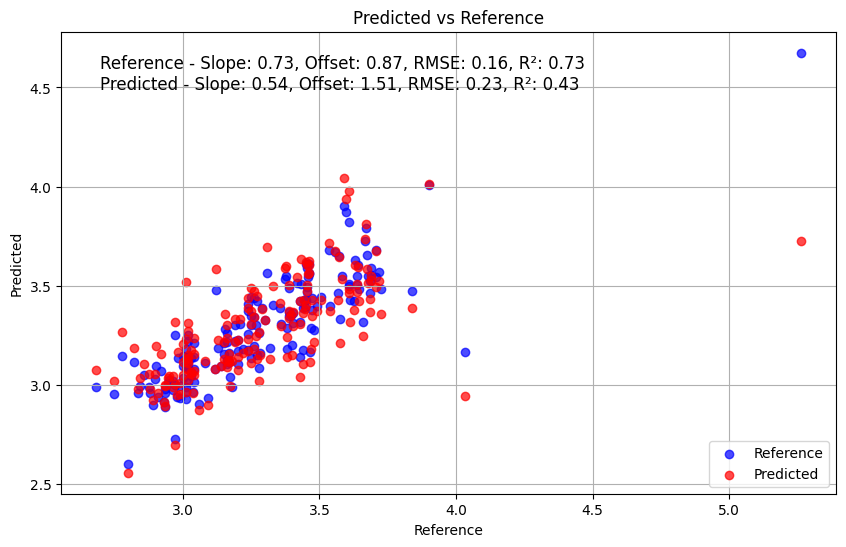

,Sample,Y_true,Y_opt,Y_pred
0,0,3.270,3.421297,3.450135
1,1,3.490,3.399330,3.371734
2,2,3.570,3.649126,3.643737
3,3,3.607,3.497262,3.463939
4,4,3.643,3.485203,3.421896
...,...,...,...,...
170,170,3.130,3.187597,3.225824
171,171,3.190,3.301825,3.332855
172,172,3.200,3.227809,3.227422
173,173,3.210,3.309143,3.331999


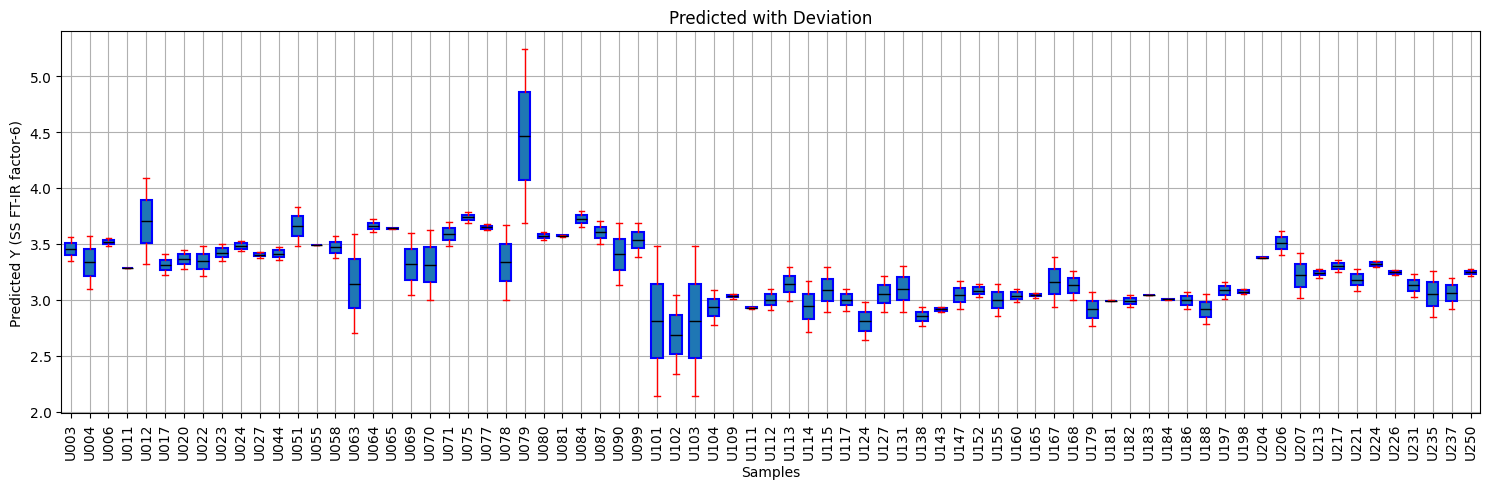

,Amostra,Y_pred,Y_true,Deviation
0,U003,3.454176,3.560,-0.105824
1,U004,3.335098,3.570,-0.234902
2,U006,3.516464,3.550,-0.033536
3,U011,3.284783,3.282,0.002783
4,U012,3.704014,3.318,0.386014
...,...,...,...,...
70,U226,3.247036,3.270,-0.022964
71,U231,3.129738,3.230,-0.100262
72,U235,3.053113,3.260,-0.206887
73,U237,3.059226,3.200,-0.140774


In [46]:
calibration_sg_ph, validation_sg_ph, Y_predict_sg_ph, plot_infos = build_model(df_sg_cal, df_sg_cal['PH'], df_sg_val, df_sg_val['PH'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'PH')

Número de componentes: 5


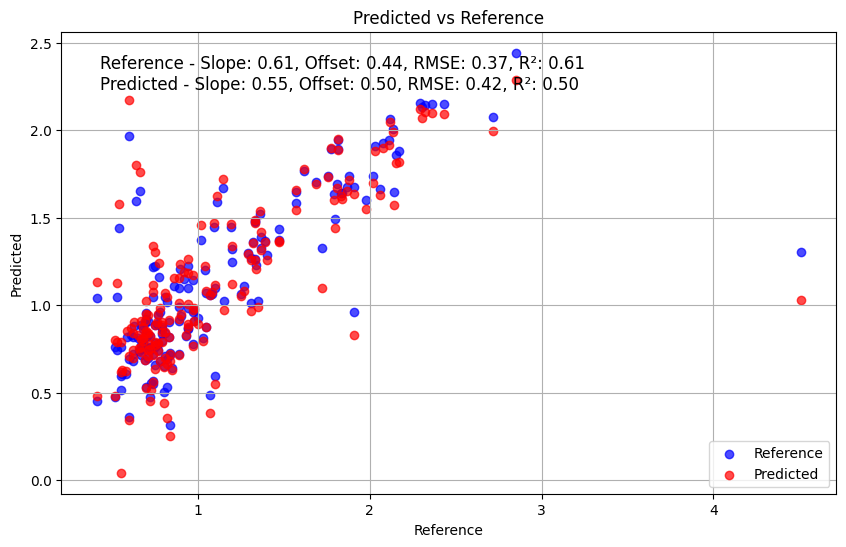

,Sample,Y_true,Y_opt,Y_pred
0,0,1.98,1.602293,1.550355
1,1,1.91,1.674368,1.634301
2,2,2.06,1.666745,1.630986
3,3,1.62,1.764791,1.776931
4,4,1.76,1.739699,1.734171
...,...,...,...,...
170,170,0.82,0.692539,0.662912
171,171,0.68,0.806692,0.815038
172,172,0.69,0.686113,0.686601
173,173,0.73,0.557173,0.516348


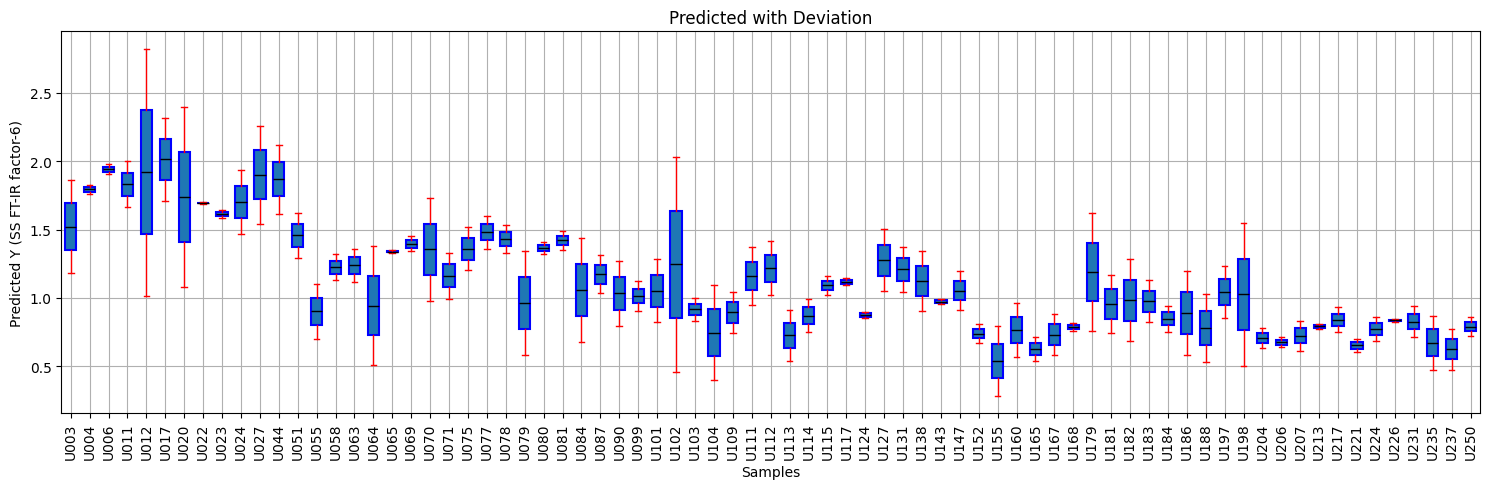

,Amostra,Y_pred,Y_true,Deviation
0,U003,1.521027,1.860,-0.338973
1,U004,1.793227,1.760,0.033227
2,U006,1.941529,1.980,-0.038471
3,U011,1.832036,2.000,-0.167964
4,U012,1.919077,1.014,0.905077
...,...,...,...,...
70,U226,0.833854,0.820,0.013854
71,U231,0.825577,0.710,0.115577
72,U235,0.670510,0.870,-0.199490
73,U237,0.622339,0.770,-0.147661


In [47]:
calibration_sg_at, validation_sg_at, Y_predict_sg_at, plot_infos = build_model(df_sg_cal, df_sg_cal['AT'], df_sg_val, df_sg_val['AT'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'AT')

Número de componentes: 6


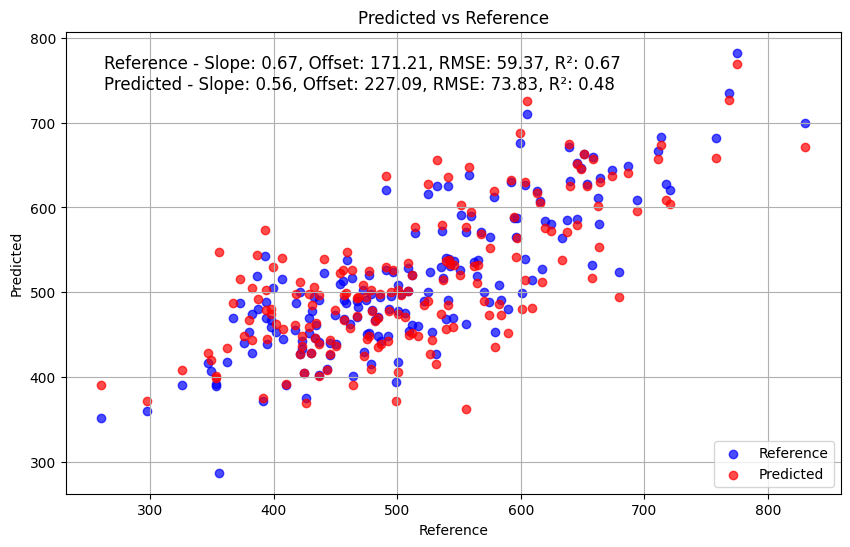

,Sample,Y_true,Y_opt,Y_pred
0,0,557.941,638.098803,648.181519
1,1,392.806,542.699741,573.560864
2,2,645.933,586.462091,579.258103
3,3,559.380,589.478874,594.196955
4,4,619.812,583.539917,575.720446
...,...,...,...,...
170,170,436.857,441.589530,438.695446
171,171,407.748,445.271833,456.588590
172,172,410.293,390.142331,391.368205
173,173,353.403,389.759008,401.208301


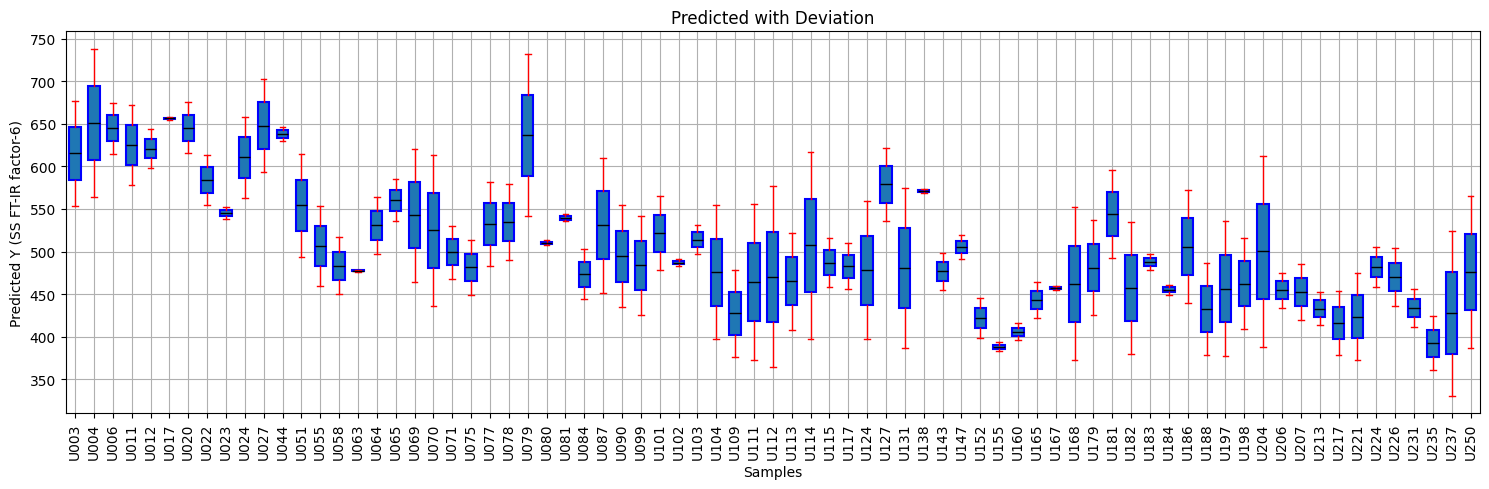

,Amostra,Y_pred,Y_true,Deviation
0,U003,615.346627,553.736,61.610627
1,U004,651.171997,564.029,87.142997
2,U006,644.979827,675.042,-30.062173
3,U011,624.897255,578.085,46.812255
4,U012,620.940188,598.008,22.932188
...,...,...,...,...
70,U226,470.017235,436.414,33.603235
71,U231,433.655450,455.451,-21.795550
72,U235,392.398814,424.239,-31.840186
73,U237,427.670291,524.627,-96.956709


In [48]:
calibration_sg_f, validation_sg_f, Y_predict_sg_f, plot_infos = build_model(df_sg_cal, df_sg_cal['FIRMEZA (N)'], df_sg_val, df_sg_val['FIRMEZA (N)'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'FIRMEZA (N)')

Número de componentes: 5


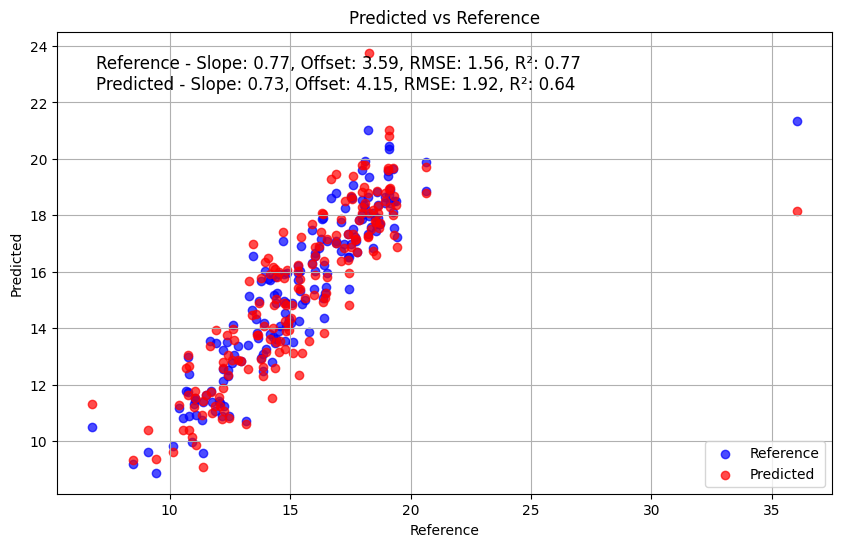

,Sample,Y_true,Y_opt,Y_pred
0,0,11.866295,11.076656,11.251644
1,1,12.206166,12.130263,11.875634
2,2,12.404207,12.296614,12.349311
3,3,14.014046,13.270078,13.140438
4,4,13.786897,12.955485,12.903956
...,...,...,...,...
170,170,16.703325,18.620239,19.272021
171,171,18.715851,17.685719,17.730103
172,172,18.260626,17.965463,18.092279
173,173,17.614441,19.066611,19.397835


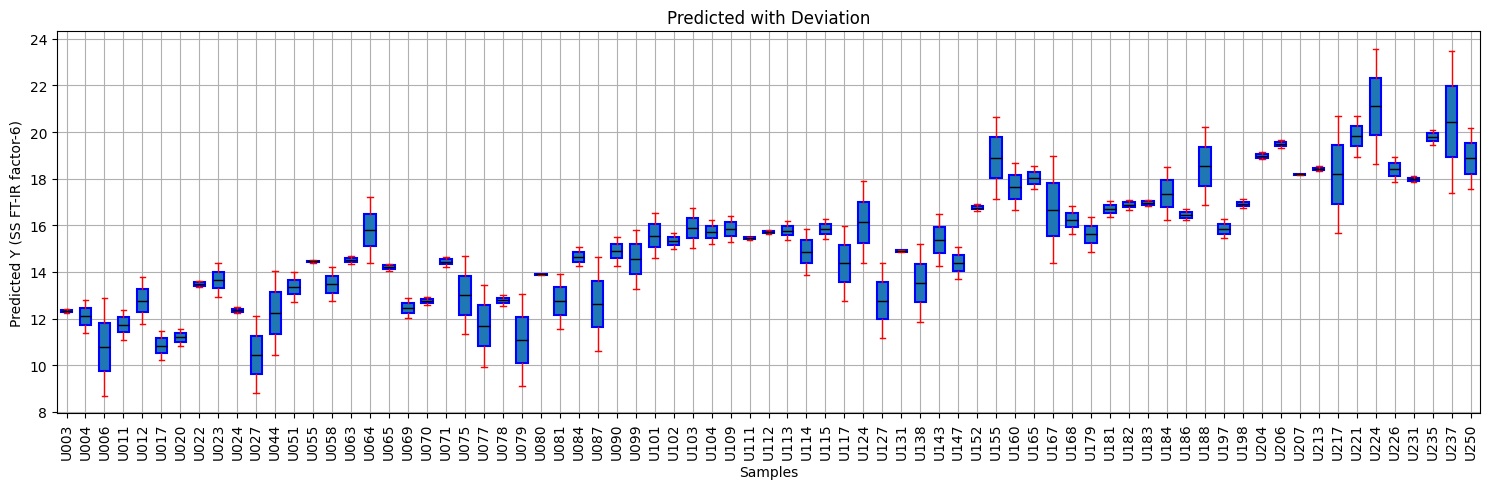

,Amostra,Y_pred,Y_true,Deviation
0,U003,12.325672,12.400951,-0.075278
1,U004,12.102217,12.813938,-0.711721
2,U006,10.783049,12.867540,-2.084491
3,U011,11.728070,12.370821,-0.642751
4,U012,12.777303,11.784548,0.992755
...,...,...,...,...
70,U226,18.398349,17.858437,0.539912
71,U231,17.976149,17.851070,0.125078
72,U235,19.783926,19.461815,0.322111
73,U237,20.440388,17.402479,3.037909


In [49]:
calibration_sg_ubs, validation_sg_ubs, Y_predict_sg_ubs, plot_infos = build_model(df_sg_cal, df_sg_cal['UBS (%)'], df_sg_val, df_sg_val['UBS (%)'])

plot_infos_sg = add_plot_infos(plot_infos_sg, plot_infos, 'UBS (%)')

In [50]:
plot_infos_sg.to_excel('plot_infos_plsr_sg.xlsx', index=False)
plot_infos_sg

,Attribute,Y,Slope,Offset,RMSE,R²
0,SST,Referência,0.846875,2.144097,1.039782,0.846875
1,SST,Predição,0.808552,2.681171,1.240912,0.781907
2,PH,Referência,0.734898,0.869933,0.159078,0.734898
3,PH,Predição,0.540553,1.508741,0.232324,0.434571
4,AT,Referência,0.608644,0.439004,0.366980,0.608644
5,AT,Predição,0.551783,0.502408,0.416639,0.495562
6,FIRMEZA (N),Referência,0.666267,171.207425,59.370814,0.666267
7,FIRMEZA (N),Predição,0.557474,227.086240,73.834109,0.483860
8,UBS (%),Referência,0.765868,3.593486,1.556336,0.765868
9,UBS (%),Predição,0.727127,4.146920,1.922450,0.642757


# Teste

In [83]:
def train_model(X_scaled, Y_scaled):
    max_lv = 10
    lvs = []
    k=1
    loo = LeaveOneOut()
    
    calibration = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'neg_root_mean_squared_error_cal', 'explained_variance_cal', 'correlation_cal', 'rpearson_cal', 'secv_cal'])
    validation = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'secv_cv'])
    
    Y_values = pd.DataFrame(index=range(len(Y_scaled)))
    Y_values['Referencia'] = Y_scaled.flatten()  # Valores reais de Y
        
    for lv in range(1, max_lv + 1):
        pls_model = PLSRegression(n_components=lv, scale=False,max_iter=100)

        # Calibração do modelo
        pls_model.fit(X_scaled, Y_scaled)
        predictions_train = pls_model.predict(X_scaled)

        # Calcula as métricas para a fase de calibração
        calibration.loc[lv, 'r2_cal'] = r2_score(Y_scaled, predictions_train)
        calibration.loc[lv, 'neg_root_mean_squared_error_cal'] = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'explained_variance_cal'] = explained_variance_score(Y_scaled, predictions_train)

        # Garantir que Y_scaled e predictions_train sejam arrays bidimensionais
        if Y_scaled.ndim == 1:
            Y_scaled = Y_scaled.reshape(-1, 1)
        if predictions_train.ndim == 1:
            predictions_train = predictions_train.reshape(-1, 1)

        correlation_cal = np.corrcoef(Y_scaled[:, 0], predictions_train[:, 0])[0, 1]  # Correlação
        calibration.loc[lv, 'correlation_cal'] = correlation_cal

        # Calcular rpearson para calibração
        rpearson_cal = correlation_cal ** 2
        calibration.loc[lv, 'rpearson_cal'] = rpearson_cal

        # Calcular o viés para calibração
        bias_cal = np.mean(predictions_train - Y_scaled)
        calibration.loc[lv, 'bias_cal'] = bias_cal

        # Calcular SE (Standard Error) para calibração
        sec_cal = np.sqrt(mean_squared_error(Y_scaled, predictions_train))
        calibration.loc[lv, 'sec_cal'] = sec_cal
        
        # Adicionar as previsões de calibração ao DataFrame Y_values
        Y_values[f'Calibracao_LV{lv}'] = predictions_train.flatten()

        # Validação cruzada (Leave-One-Out)
        predictions_cv = cross_val_predict(pls_model, X_scaled, Y_scaled, cv=loo)

        # Calcula as métricas para a validação cruzada
        validation.loc[lv, 'r2_cv'] = r2_score(Y_scaled, predictions_cv)
        validation.loc[lv, 'neg_root_mean_squared_error_cv'] = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'explained_variance_cv'] = explained_variance_score(Y_scaled, predictions_cv)

        # Garantir que predictions_cv seja array bidimensional
        if predictions_cv.ndim == 1:
            predictions_cv = predictions_cv.reshape(-1, 1)

        correlation_cv = np.corrcoef(Y_scaled[:, 0], predictions_cv[:, 0])[0, 1]  # Correlação
        validation.loc[lv, 'correlation_cv'] = correlation_cv

        # Calcular rpearson para validação cruzada
        rpearson_cv = correlation_cv ** 2
        validation.loc[lv, 'rpearson_cv'] = rpearson_cv

        # Calcular o viés para validação cruzada
        bias_cv = np.mean(predictions_cv - Y_scaled)
        validation.loc[lv, 'bias_cv'] = bias_cv

        # Calcular SECV (Standard Error of Cross Validation)
        secv_cv = np.sqrt(mean_squared_error(Y_scaled, predictions_cv))
        validation.loc[lv, 'secv_cv'] = secv_cv
        
        # Adicionar as previsões de validação ao DataFrame Y_values
        Y_values[f'Validacao_LV{lv}'] = predictions_cv.flatten()
    
        mean_explained_variance = validation['r2_cv'].values
        
        min_index = 10
        
        for i in range(1, len(mean_explained_variance)):
            diff = mean_explained_variance[i] - mean_explained_variance[i - 1]
            decrease = mean_explained_variance[i] < mean_explained_variance[i - 1]
            if diff <= 0.009 or decrease:
                min_index = i  # Armazena o índice anterior
                break
        
        lv_num = min_index + 1
        
        pls_model = PLSRegression(n_components=lv_num)
        model = pls_model.fit(X_scaled, Y_scaled)

    
    return calibration, validation, lv_num, model, Y_values

def center_data(X, Y):
    # Calcula as médias para cada coluna
    mx = np.mean(X, axis=0)
    
    # Calcula a média para Y
    my = np.mean(Y)
    
    # Centraliza as colunas na média
    abs_centered = X - mx
    qua_centered = Y - my
       
    return abs_centered, qua_centered, mx, my

def predict(model, X_pred, y_pred, lv_number):
    X_centered, _, _, _ = center_data(X_pred.iloc[:,6:].values, y_pred.values)
    pred = model.predict(X_pred.iloc[:,6:].values)
       
    y_pred = y_pred.values  # Convertendo Series para NumPy array
    pred = pred.reshape(-1, 1)  # Garantindo que pred seja 2D

    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    Y_predict = pd.DataFrame(columns=['Amostra', 'Y_pred', 'Y_true', 'Deviation', 'RMSEP'])
    
    prediction = pd.DataFrame(columns=['r2_cv', 'neg_root_mean_squared_error_cv', 'explained_variance_cv', 'correlation_cv', 'rpearson_cv', 'bias_cv', 'secv_cv'])
    
    prediction.loc[lv_number, 'r2_p'] = r2_score(y_pred, pred)
    prediction.loc[lv_number, 'neg_root_mean_squared_error_p'] = np.sqrt(mean_squared_error(y_pred, pred))
    prediction.loc[lv_number, 'explained_variance_p'] = explained_variance_score(y_pred, pred)
    prediction.loc[lv_number, 'correlation_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1]
    prediction.loc[lv_number, 'rpearson_p'] = np.corrcoef(y_pred[:, 0], pred[:, 0])[0, 1] ** 2  # Quadrado do coeficiente de correlação
    prediction.loc[lv_number, 'bias_p'] = np.mean(pred - y_pred)  # Viés
    prediction.loc[lv_number, 'sec_p'] = np.sqrt(np.mean((pred - y_pred) ** 2))  # Erro quadrático de calibração
    
    Y_predict['Y_pred'] = pred.flatten()
    Y_predict['Y_true'] = y_pred.flatten()
    Y_predict['Deviation'] = pred.flatten() - y_pred.flatten()
    Y_predict['Amostra'] = X_pred.iloc[0:,0].tolist()
    Y_predict['RMSEP'] = mean_squared_error(y_pred, pred)
    
    return prediction, Y_predict

def plot_pred_vs_ref(Y_true, Y_pred, Y_opt, title="Predicted vs Reference"):
    
    slope_pred, offset_pred = np.polyfit(Y_true, Y_pred, 1)
    rmse_pred = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2_pred = r2_score(Y_true, Y_pred)
    
    slope_opt, offset_opt = np.polyfit(Y_true, Y_opt, 1)
    rmse_opt = np.sqrt(mean_squared_error(Y_true, Y_opt))
    r2_opt = r2_score(Y_true, Y_opt)
    
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for reference values
    plt.scatter(Y_true, Y_opt, color='blue', label='Reference', marker='o', alpha=0.7)
    
    # Scatter plot for predicted values
    plt.scatter(Y_true, Y_pred, color='red', label='Predicted', marker='o', alpha=0.7)
       
    plt.xlabel("Reference")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
    plt.legend(loc='lower right')
    plt.show()

def pred_plot(Y_predict):
    plt.figure(figsize=(15, 5))
    plt.title("Predicted with Deviation")

    # Plotar cada amostra
    for sample in Y_predict.index:
        y_pred = Y_predict.loc[sample, 'Y_pred']
        deviation = Y_predict.loc[sample, 'Deviation']
        y_true = Y_predict.loc[sample, 'Y_true']
        
        # Criar os dados do boxplot para esta amostra
        data_boxplot = [y_pred - deviation, y_pred, y_pred + deviation]
        
        # Plotar o boxplot
        plt.boxplot(data_boxplot, positions=[Y_predict.index.get_loc(sample)], widths=0.6, patch_artist=True, 
                    boxprops=dict(edgecolor='blue', linewidth=1.5),
                    whiskerprops=dict(color='red'),
                    capprops=dict(color='red'),
                    medianprops=dict(color='black'))
        
    plt.xticks(ticks=range(len(Y_predict.index)), labels=Y_predict['Amostra'], rotation=90)
    plt.xlabel('Samples')
    plt.ylabel('Predicted Y (SS FT-IR factor-6)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def build_model(X_cal, Y_cal, X_val, Y_val):
       
    Y_pred = Y_val
    X_pred = X_val
       
    X = X_cal
    Y = Y_cal
    
    #abs_scaled, qua_scaled, m_abs, m_qua = center_data(X.iloc[:,6:].values, Y.values)
    calibration, validation, lv_num, model, Y_values = train_model(X.iloc[:,6:].values, Y.values)
    print(lv_num)
        
    prediction, Y_predict = predict(model, X_pred, Y_pred, lv_num)
    
    Y_true = Y_values.iloc[:, 0]  # Primeira coluna de Y_values
    Y_opt = Y_values[f'Calibracao_LV{lv_num}']  # Coluna específica de calibração
    Y_pred = Y_values[f'Validacao_LV{lv_num}']  # Coluna específica de validação
    plot_pred_vs_ref(Y_true, Y_pred, Y_opt)  
    pred_plot(Y_predict)
    
    return calibration, validation, Y_predict
    
    
    


In [102]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

def plsr(X, Y, n_components):
    # Converter X e Y para arrays NumPy de float
    X = np.asarray(X, dtype=float)
    Y = np.asarray(Y, dtype=float).reshape(-1, 1)
    # Inicialização
    T = []  # Scores
    P = []  # X loadings
    Q = []  # Y loadings
    W = []  # Weights
    U = []  # Y Scores
    E = X.copy()
    F = Y.copy()

    for _ in range(n_components):
        # 1. Calcular o vetor de peso w
        S = np.dot(E.T, F)
        eigvals, eigvecs = np.linalg.eig(np.dot(S, S.T))
        w = eigvecs[:, np.argmax(eigvals)]
        w = w.real  # Tomar apenas a parte real de w
        w = w / np.linalg.norm(w)  # Normalizar

        # 2. Calcular o score t
        t = np.dot(E, w)

        # 3. Calcular o loading p
        p = np.dot(E.T, t) / np.dot(t.T, t)

        # 4. Calcular o loading q
        q = np.dot(F.T, t) / np.dot(t.T, t)

        # 5. Calcular o score u
        u = np.dot(F, q) / np.dot(q.T, q)

        # 6. Armazenar T, P, Q, W, U
        T.append(t)
        P.append(p)
        Q.append(q)
        W.append(w)
        U.append(u)

        # 7. Atualizar E e F
        E = E - np.outer(t, p.T)
        F = F - np.outer(t, q.T)

    T = np.array(T).T
    P = np.array(P).T
    Q = np.array(Q).T
    W = np.array(W).T
    U = np.array(U).T

    # Calcular B (coeficientes de regressão)
    B = np.dot(np.dot(np.dot(W, np.linalg.inv(np.dot(T.T, T))), T.T), Y)

    return B, T, P, Q, W, U

def calculate_metrics(Y_true, Y_pred):
    
    Y_true = np.asarray(Y_true, dtype=float)
    Y_pred = np.asarray(Y_pred, dtype=float)
    
    # Certificar-se de que Y_true e Y_pred são 2D
    if Y_true.ndim == 1:
        Y_true = Y_true.reshape(-1, 1)
    if Y_pred.ndim == 1:
        Y_pred = Y_pred.reshape(-1, 1)
        
        
    r2 = r2_score(Y_true, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    explained_variance = explained_variance_score(Y_true, Y_pred)
    correlation = np.corrcoef(Y_true[:, 0], Y_pred[:, 0])[0, 1]
    r2_pearson = correlation ** 2
    bias = np.mean(Y_pred - Y_true)
    
    return {
        "r2": r2,
        "rmse": rmse,
        "explained_variance": explained_variance,
        "correlation": correlation,
        "r2_pearson": r2_pearson,
        "bias": bias
    }


#calibration_msc_sst, validation_msc_sst, Y_predict_msc_sst = build_model(df_msc_cal, df_msc_cal['SST'], df_msc_val, df_msc_val['SST'])

# Exemplo de uso
n_components = 10
X=df_msc_cal.iloc[:,6:].values
Y=df_msc_cal['SST'].values

B, T, P, Q, W, U = plsr(df_msc_cal.iloc[:,6:].values, df_msc_cal['SST'].values, n_components)

# Fazer previsões
Y_pred = np.dot(X, B)

# Calcular as métricas
metrics = calculate_metrics(Y, Y_pred)
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")


r2: 0.4129
rmse: 2.0354
explained_variance: 0.4167
correlation: 0.6721
r2_pearson: 0.4517
bias: -0.1634


In [103]:
# Dados de calibração
X = df_msc_cal.iloc[:, 6:].values
Y = df_msc_cal['SST'].values

max_lv = 10  # Número máximo de componentes
results = pd.DataFrame(index=range(1, max_lv + 1), columns=['r2_cal', 'rmse_cal', 'explained_variance_cal', 'correlation_cal', 'r2_pearson_cal', 'bias_cal'])

for n_components in range(1, max_lv + 1):
    # Treine o modelo
    B, _, _, _, _, _ = plsr(X, Y, n_components)

    # Faça previsões
    Y_pred = np.dot(X, B)

    # Calcule as métricas
    metrics = calculate_metrics(Y, Y_pred)
    
    # Armazene os resultados
    results.loc[n_components, 'r2_cal'] = metrics['r2']
    results.loc[n_components, 'rmse_cal'] = metrics['rmse']
    results.loc[n_components, 'explained_variance_cal'] = metrics['explained_variance']
    results.loc[n_components, 'correlation_cal'] = metrics['correlation']
    results.loc[n_components, 'r2_pearson_cal'] = metrics['r2_pearson']
    results.loc[n_components, 'bias_cal'] = metrics['bias']

print(results)


      r2_cal  rmse_cal explained_variance_cal correlation_cal r2_pearson_cal  \
1   0.001835  2.653958               0.001835        0.489659       0.239765   
2   0.323039   2.18562               0.326847        0.571705       0.326847   
3   0.377961  2.095084               0.381746        0.627112        0.39327   
4   0.428977  2.007333               0.432764        0.696186       0.484675   
5   0.428431  2.008293               0.432217        0.695356       0.483521   
6   0.438868  1.989873               0.442653        0.712497       0.507652   
7   0.452716  1.965166               0.456501        0.737299        0.54361   
8   0.457436  1.956673               0.461221        0.746368       0.557065   
9   0.407961  2.043938               0.411747        0.665086        0.44234   
10  0.412915   2.03537                 0.4167         0.67205       0.451652   

    bias_cal  
1   0.000462  
2  -0.163926  
3  -0.163417  
4  -0.163471  
5  -0.163453  
6  -0.163444  
7  -0.163444  

In [104]:
# Exemplo de uso
n_components = 10
X=df_msc_cal.iloc[:,6:].values
Y=df_msc_cal['SST'].values
X, Y, _, _ = center_data(X, Y)

B, T, P, Q, W, U = plsr(df_msc_cal.iloc[:,6:].values, df_msc_cal['SST'].values, n_components)

# Fazer previsões
Y_pred = np.dot(X, B)

# Calcular as métricas
metrics = calculate_metrics(Y, Y_pred)
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

r2: 0.4167
rmse: 2.0288
explained_variance: 0.4167
correlation: 0.6721
r2_pearson: 0.4517
bias: 0.0000
